# Collaborative Healthcare Data Analysis
This project analyzes healthcare data using Python and Google Colab.
It focuses on disease risk assessment, demographic comparison, and trend analysis.
Gender-based risk differences and time-based health trends are evaluated.
Machine learning models are applied for prediction and interpretation.
The project is designed for collaborative, real-world data analysis practice.


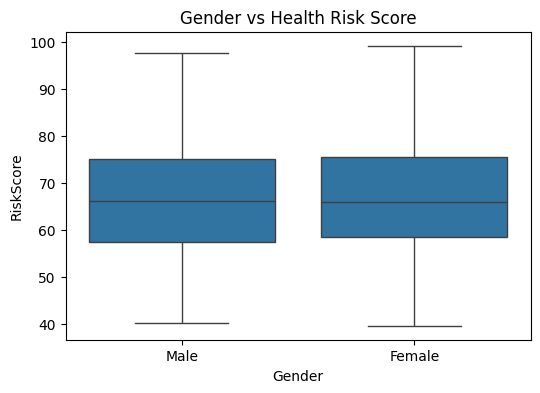

Gender risk comparison p-value: 0.2876


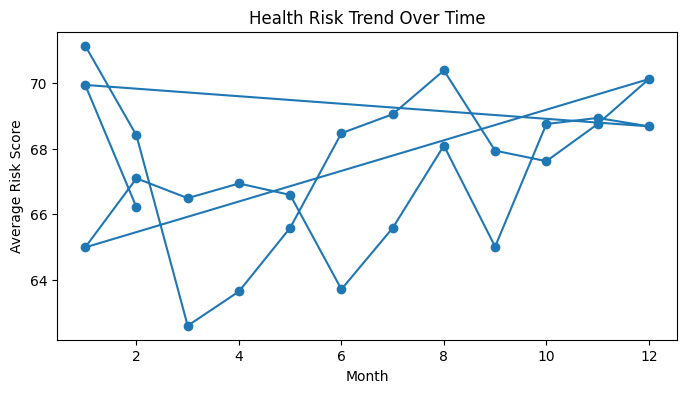

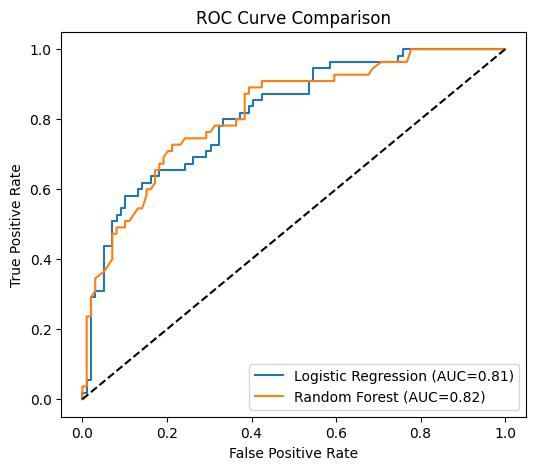

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: U

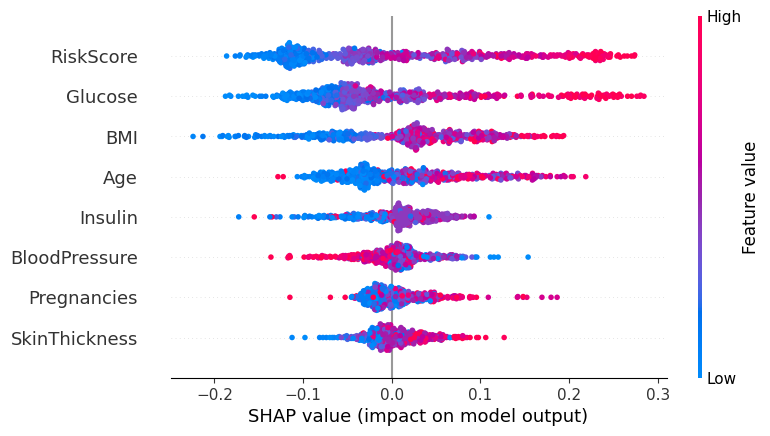

In [6]:
# Install required libraries
!pip install -q seaborn scikit-learn shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import ttest_ind

# Reproducibility
rng = np.random.default_rng(42)

# Load dataset
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

# Add gender and time features
df["Gender"] = rng.choice(["Male", "Female"], size=len(df))
df["Checkup_Date"] = pd.date_range(start="2021-01-01", periods=len(df), freq="D")
df["Year"] = df["Checkup_Date"].dt.year
df["Month"] = df["Checkup_Date"].dt.month

# Data cleaning
cols_with_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Feature engineering
df["AgeGroup"] = pd.cut(
    df["Age"],
    [20, 30, 40, 50, 60, 100],
    labels=["20s", "30s", "40s", "50s", "60+"]
)

df["RiskScore"] = (
    0.3 * df["Glucose"] +
    0.3 * df["BMI"] +
    0.2 * df["Age"] +
    0.2 * df["BloodPressure"]
)

# Gender-based risk analysis
plt.figure(figsize=(6, 4))
sns.boxplot(x="Gender", y="RiskScore", data=df)
plt.title("Gender vs Health Risk Score")
plt.show()

male_risk = df[df["Gender"] == "Male"]["RiskScore"]
female_risk = df[df["Gender"] == "Female"]["RiskScore"]
_, p_val = ttest_ind(male_risk, female_risk)
print("Gender risk comparison p-value:", round(p_val, 5))

# Time-based trend analysis
monthly_trend = df.groupby(["Year", "Month"])["RiskScore"].mean().reset_index()

plt.figure(figsize=(8, 4))
plt.plot(monthly_trend["Month"], monthly_trend["RiskScore"], marker="o")
plt.xlabel("Month")
plt.ylabel("Average Risk Score")
plt.title("Health Risk Trend Over Time")
plt.show()

# Prepare data for machine learning
X = df[
    ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
     "Insulin", "BMI", "Age", "RiskScore"]
]
y = df["Outcome"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train models
log_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

log_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# ROC curve comparison
log_prob = log_model.predict_proba(X_test)[:, 1]
rf_prob = rf_model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(6, 5))
for prob, label in zip(
    [log_prob, rf_prob],
    ["Logistic Regression", "Random Forest"]
):
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc_score(y_test, prob):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# =========================
# FINAL STABLE SHAP SECTION
# =========================

# Convert to DataFrame for SHAP
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Use unified, model-agnostic SHAP explainer
explainer = shap.Explainer(
    rf_model.predict_proba,
    X_train_df
)

shap_values = explainer(X_train_df)

# Beeswarm plot for positive class (Outcome = 1)
shap.plots.beeswarm(shap_values[:, :, 1])


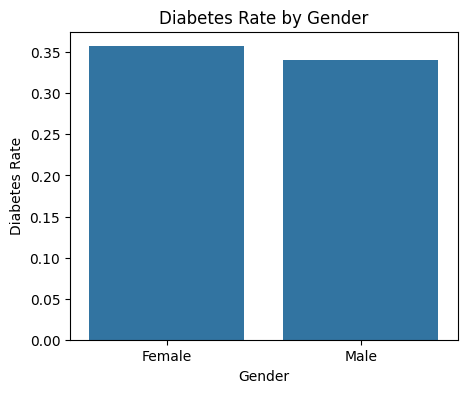

In [7]:
#Diabetes Rate by Gender (Percentage View)
gender_outcome = (
    df.groupby("Gender")["Outcome"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(5,4))
sns.barplot(x="Gender", y="Outcome", data=gender_outcome)
plt.ylabel("Diabetes Rate")
plt.title("Diabetes Rate by Gender")
plt.show()


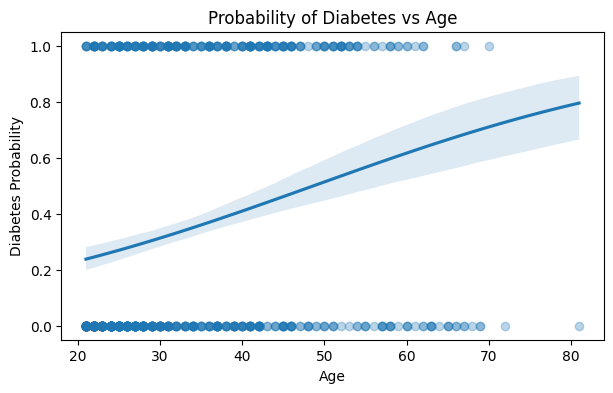

In [8]:
#Age vs Diabetes Probability (Smooth Trend)
plt.figure(figsize=(7,4))
sns.regplot(
    x="Age",
    y="Outcome",
    data=df,
    logistic=True,
    scatter_kws={"alpha":0.3}
)
plt.title("Probability of Diabetes vs Age")
plt.xlabel("Age")
plt.ylabel("Diabetes Probability")
plt.show()


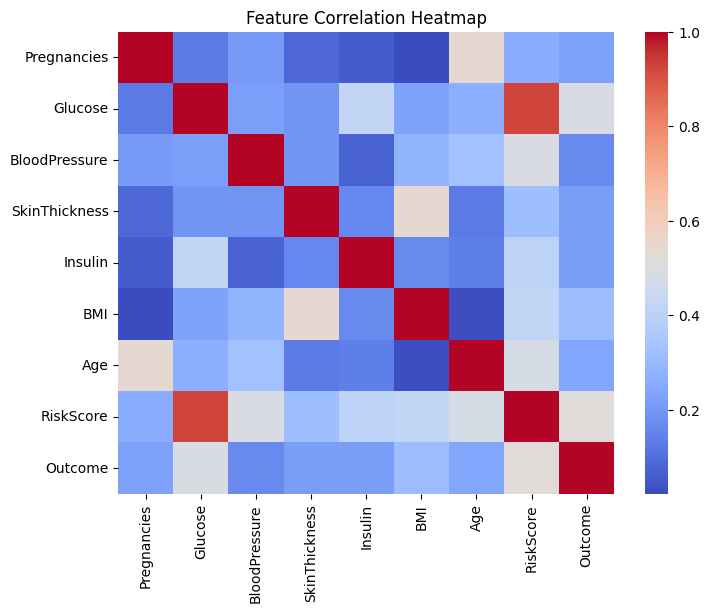

In [9]:
#Correlation Heatmap (Clean Feature View)
plt.figure(figsize=(8,6))
sns.heatmap(
    df[X.columns.tolist() + ["Outcome"]].corr(),
    annot=False,
    cmap="coolwarm"
)
plt.title("Feature Correlation Heatmap")
plt.show()
